In [1]:
## PYTHON MODULES

from pyspark.sql import SparkSession
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re

In [2]:
## FUNCTIONS

def getYear(x):
    return int(datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y').strftime('%Y'))

def parseDate(x):
    return str(datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y').strftime('%Y-%m-%d'))

emoticons_str = r"""
    (?:
    [:=;] # Eyes
    [oO\-]? # Nose (optional)
    [D\)\]\(\]/\\OpP] # Mouth
    )"""
    
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hashtags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
stop_words = stopwords.words('english') + list(string.punctuation) + ['rt', 'via', 'amp', '’', '…', '—', '“', '”']

def preprocessText(s):    
    tokens = tokens_re.findall(s)
    tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

In [3]:
# Create spark session
spark = SparkSession \
    .builder \
    .enableHiveSupport() \
    .getOrCreate()

In [4]:
# Read in twitter user party affiliation
partyAffiliation = pd.read_csv("twitter_handles_final.csv")

democrats = partyAffiliation[partyAffiliation.party == 'D']
republicans = partyAffiliation[partyAffiliation.party == 'R']

In [5]:
# Create rdd from twitter json file
tweetsRDD = spark.sparkContext.textFile("congress_tweets.jsonl").map(json.loads)

# Filter out tweets earlier than 2017
tweetsRDD = tweetsRDD.filter(lambda tweet: getYear(tweet['created_at']) >= 2017)

In [6]:
# Count number of user followers
userFollowerCountsRDD = (tweetsRDD
                         .map(lambda tweet: (tweet['user']['screen_name'], tweet['user']['followers_count']))
                         .reduceByKey(max)
                        )

In [7]:
# Convert to dataframe, sort by descending order, and merge party info
columns = ['user', 'followers']
userFollowerCounts = userFollowerCountsRDD.toDF(columns).toPandas()
userFollowerCounts = userFollowerCounts.sort_values('followers', ascending = False)
userFollowerCounts = userFollowerCounts.merge(partyAffiliation, how = 'inner', on = 'user')

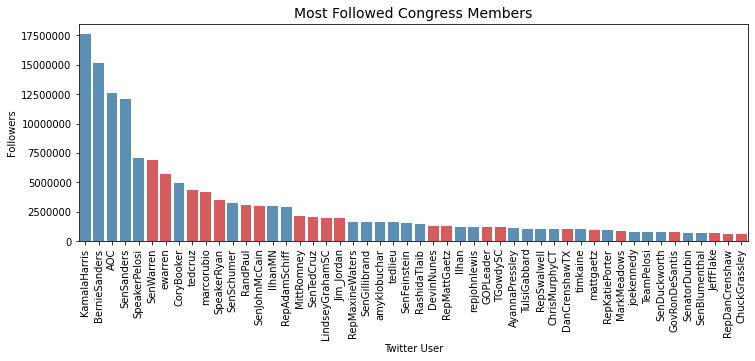

In [8]:
# Plot users with most followers
plt.figure(figsize = (12, 4))
sns.barplot(x = 'user', y = 'followers', data = userFollowerCounts.head(50), 
            hue = 'party', palette = ["#1F78B4", "#E31A1C"], dodge = False, alpha = 0.8)
plt.xlabel('Twitter User')
plt.ylabel('Followers')
plt.xticks(rotation = 90, fontsize = 10)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.title("Most Followed Congress Members", fontsize = 14)
plt.legend([],[], frameon = False)
plt.show()

In [9]:
# Count number of user tweets 
userTweetCountsRDD = (tweetsRDD
                      .map(lambda tweet: (tweet['user']['screen_name'], 1))
                      .reduceByKey(lambda a, b: a + b)
                     )

In [10]:
# Convert to dataframe, sort by descending order, and merge party info
columns = ['user', 'tweets']
userTweetCounts = userTweetCountsRDD.toDF(columns).toPandas()
userTweetCounts = userTweetCounts.sort_values('tweets', ascending = False)
userTweetCounts = userTweetCounts.merge(partyAffiliation, how = 'inner', on = 'user')

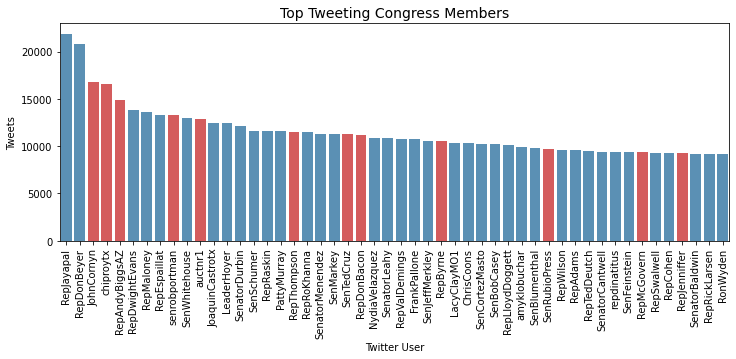

In [11]:
# Plot users with most tweets
plt.figure(figsize = (12, 4))
sns.barplot(x = 'user', y = 'tweets', data = userTweetCounts.head(50),
            hue = 'party', palette = ["#1F78B4", "#E31A1C"], dodge = False, alpha = 0.8)
plt.xlabel('Twitter User')
plt.ylabel('Tweets')
plt.xticks(rotation = 90, fontsize = 10)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.title("Top Tweeting Congress Members", fontsize = 14)
plt.legend([],[], frameon = False)
plt.show()

In [12]:
# Count hashtag usage frequency
hashtagCountsRDD = (tweetsRDD
                    .flatMap(lambda tweet: [hashtag['text'].lower() for hashtag in tweet["entities"]["hashtags"]])
                    .map(lambda hashtag: (hashtag, 1))
                    .reduceByKey(lambda a, b: a + b)
                   )

In [13]:
# Convert to dataframe and sort by descending order
columns = ['hashtag', 'tweets']
hashtagCounts = hashtagCountsRDD.map(lambda kv: (kv[0], kv[1])).toDF(columns).toPandas()
hashtagCounts = hashtagCounts.sort_values('tweets', ascending = False)

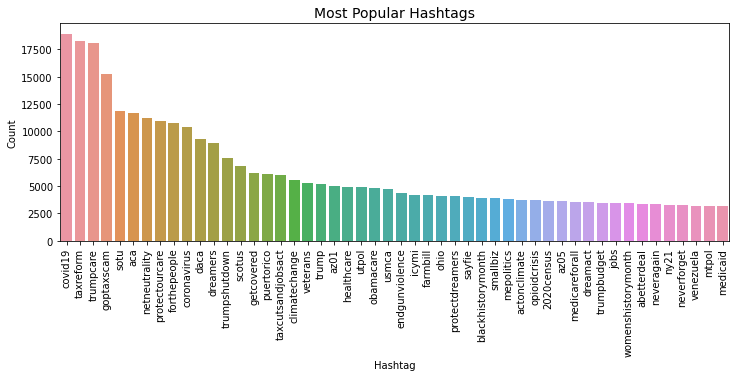

In [14]:
# Plot most popular hashtags
plt.figure(figsize = (12, 4))
sns.barplot(x = 'hashtag', y = 'tweets', data = hashtagCounts.head(50))
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.xticks(rotation = 90, fontsize = 10)
plt.title("Most Popular Hashtags", fontsize = 14)
plt.show()

In [15]:
# Calculate average number of retweets per user
userAverageRetweetsRDD = (tweetsRDD
                          .map(lambda tweet: (tweet['user']['screen_name'], tweet['retweet_count']))
                          .mapValues(lambda x: (x, 1))
                          .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
                          .mapValues(lambda x: x[0] / x[1])
                         )

In [16]:
# Convert to dataframe and sort by descending order
columns = ['user', 'retweets']
userAverageRetweets = userAverageRetweetsRDD.map(lambda kv: (kv[0], kv[1])).toDF(columns).toPandas()
userAverageRetweets = userAverageRetweets.sort_values('retweets', ascending = False)
userAverageRetweets = userAverageRetweets.merge(partyAffiliation, how = 'inner', on = 'user')

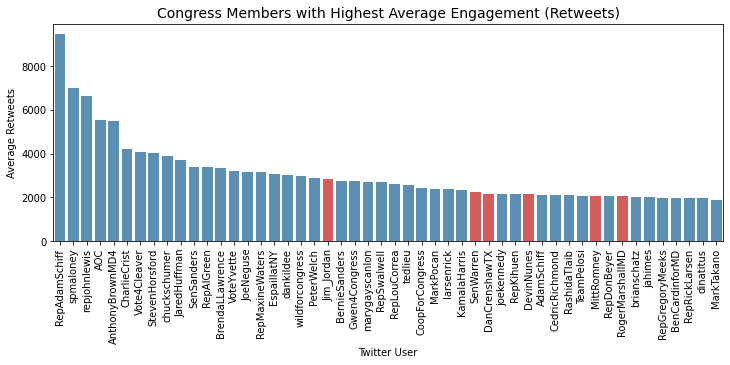

In [17]:
# Plot users with highest average engagement
plt.figure(figsize = (12, 4))
sns.barplot(x = 'user', y = 'retweets', data = userAverageRetweets.head(50),
            hue = 'party', palette = ["#1F78B4", "#E31A1C"], dodge = False, alpha = 0.8)
plt.xlabel('Twitter User')
plt.ylabel('Average Retweets')
plt.xticks(rotation = 90, fontsize = 10)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.title("Congress Members with Highest Average Engagement (Retweets)", fontsize = 14)
plt.legend([],[], frameon = False)
plt.show()

In [18]:
# Count number of tweets by date
dateTweetCountsRDD = (tweetsRDD
                      .map(lambda tweet: (parseDate(tweet['created_at']), 1))
                      .reduceByKey(lambda a, b: a + b)
                     )

In [19]:
# Convert to dataframe and sort by descending order
columns = ['date', 'tweets']
dateTweetCounts = dateTweetCountsRDD.map(lambda kv: (kv[0], kv[1])).toDF(columns).toPandas()
dateTweetCounts = dateTweetCounts.sort_values('tweets', ascending = False)
# dateTweetCounts.head(10)

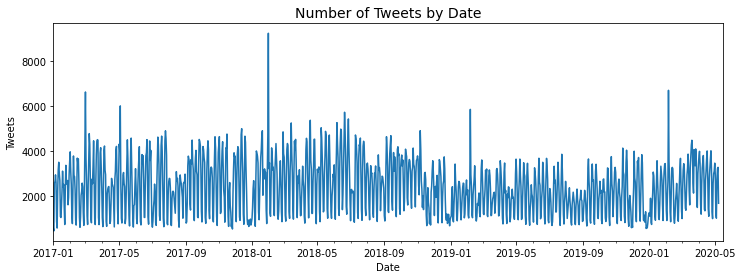

In [20]:
# Plot number of tweets by date
dateTweetCounts.date = pd.to_datetime(dateTweetCounts.date, format = '%Y-%m-%d')

fig, ax = plt.subplots(figsize = (12, 4))
sns.lineplot(x = 'date', y = 'tweets', data = dateTweetCounts)
plt.xlabel('Date')
plt.ylabel('Tweets')
plt.xlim(pd.to_datetime(['2017-01-01','2020-05-15'], format = '%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval = 1))
plt.title("Number of Tweets by Date", fontsize = 14)
plt.show()

In [21]:
# Count number of democrat tweets by date
dateTweetCountsDemRDD = (tweetsRDD
                         .filter(lambda tweet: tweet['user']['screen_name'] in democrats['user'].tolist())
                         .map(lambda tweet: (parseDate(tweet['created_at']), 1))
                         .reduceByKey(lambda a, b: a + b)
                        )

# Count number of republican tweets by date
dateTweetCountsRepRDD = (tweetsRDD
                         .filter(lambda tweet: tweet['user']['screen_name'] in republicans['user'].tolist())
                         .map(lambda tweet: (parseDate(tweet['created_at']), 1))
                         .reduceByKey(lambda a, b: a + b)
                        )

In [22]:
# Convert to dataframe and sort by descending order
columns = ['date', 'tweets']
dateTweetCountsDem = dateTweetCountsDemRDD.toDF(columns).toPandas()
dateTweetCountsDem = dateTweetCountsDem.sort_values('tweets', ascending = False)

# Convert to dataframe and sort by descending order
columns = ['date', 'tweets']
dateTweetCountsRep = dateTweetCountsRepRDD.toDF(columns).toPandas()
dateTweetCountsRep = dateTweetCountsRep.sort_values('tweets', ascending = False)

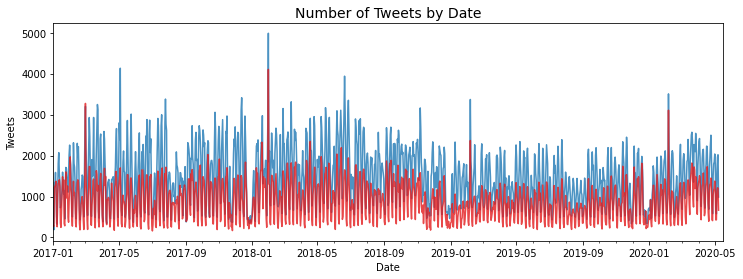

In [23]:
# Plot number of tweets by date
dateTweetCountsDem['party'], dateTweetCountsRep['party'] = 'D', 'R'
dateTweetCountsDemRep = dateTweetCountsDem.append(dateTweetCountsRep)
dateTweetCountsDemRep['date'] = pd.to_datetime(dateTweetCountsDemRep['date'], format = '%Y-%m-%d')

fig, ax = plt.subplots(figsize = (12, 4))
sns.set_palette(["#1F78B4", "#E31A1C"])
sns.lineplot(x = 'date', y = 'tweets', data = dateTweetCountsDemRep, 
             hue = 'party', palette = ["#1F78B4", "#E31A1C"], alpha = 0.8)
plt.xlabel('Date')
plt.ylabel('Tweets')
plt.xlim(pd.to_datetime(['2017-01-01','2020-05-15'], format = '%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval = 1))
plt.title("Number of Tweets by Date", fontsize = 14)
plt.legend([],[], frameon = False)
plt.show()

In [24]:
# Count number of retweets by date and user (take max retweet count per user on given date)
dateRetweetCountsRDD = (tweetsRDD
                        .map(lambda tweet: ((parseDate(tweet['created_at']),
                                             tweet['user']['screen_name']),
                                            tweet['retweet_count']))
                        .reduceByKey(max)
                       )

In [25]:
# Convert to dataframe and sort by descending order
columns = ['date','user', 'retweets']
dateRetweetCounts = dateRetweetCountsRDD.map(lambda kv: (kv[0][0], kv[0][1], kv[1])).toDF(columns).toPandas()
dateRetweetCounts = dateRetweetCounts.sort_values('retweets', ascending = False)

In [26]:
# Calculate median retweets by date
dateMedianRetweets = dateRetweetCounts.groupby('date').median().reset_index()
dateMedianRetweets = dateMedianRetweets.sort_values('retweets', ascending = False)
# dateMedianRetweets.to_csv("median_retweets_by_date.csv", header = True)
# dateMedianRetweets.head(10)

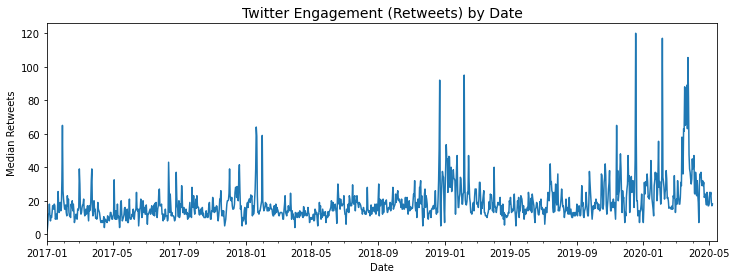

In [27]:
# Plot median retweets by date
dateMedianRetweets['date'] = pd.to_datetime(dateMedianRetweets['date'], format = '%Y-%m-%d')

fig, ax = plt.subplots(figsize = (12, 4))
sns.lineplot(x = 'date', y = 'retweets', data = dateMedianRetweets)
plt.xlabel('Date')
plt.ylabel('Median Retweets')
plt.xlim(pd.to_datetime(['2017-01-01','2020-05-15'], format = '%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval = 1))
plt.title("Twitter Engagement (Retweets) by Date", fontsize = 14)
plt.show()

In [28]:
# Count number of democrat retweets by date and user (take max retweet count per user on given date)
dateRetweetCountsDemRDD = (tweetsRDD
                           .filter(lambda tweet: tweet['user']['screen_name'] in democrats['user'].tolist())
                           .map(lambda tweet: ((parseDate(tweet['created_at']),
                                                tweet['user']['screen_name']),
                                               tweet['retweet_count']))
                           .mapValues(lambda x: (x, 1))
                           .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
                           .mapValues(lambda x: x[0] / x[1])
                          )

# Count number of republican retweets by date and user (take max retweet count per user on given date)
dateRetweetCountsRepRDD = (tweetsRDD
                           .filter(lambda tweet: tweet['user']['screen_name'] in republicans['user'].tolist())
                           .map(lambda tweet: ((parseDate(tweet['created_at']),
                                                tweet['user']['screen_name']),
                                               tweet['retweet_count']))
                           .mapValues(lambda x: (x, 1))
                           .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
                           .mapValues(lambda x: x[0] / x[1])
                          )

In [29]:
# Convert to dataframe and sort by descending order
columns = ['date','user', 'retweets']
dateRetweetCountsDem = dateRetweetCountsDemRDD.map(lambda kv: (kv[0][0], kv[0][1], kv[1])).toDF(columns).toPandas()
dateRetweetCountsDem = dateRetweetCountsDem.sort_values('retweets', ascending = False)

# Convert to dataframe and sort by descending order
columns = ['date','user', 'retweets']
dateRetweetCountsRep = dateRetweetCountsRepRDD.map(lambda kv: (kv[0][0], kv[0][1], kv[1])).toDF(columns).toPandas()
dateRetweetCountsRep = dateRetweetCountsRep.sort_values('retweets', ascending = False)

In [30]:
# Calculate median democrat retweets by date
dateMedianRetweetsDem = dateRetweetCountsDem.groupby('date').median().reset_index()
dateMedianRetweetsDem = dateMedianRetweetsDem.sort_values('retweets', ascending = False)
# dateMedianRetweetsDem.to_csv("median_democrat_retweets_by_date.csv", header = True)

# Calculate median republican retweets by date
dateMedianRetweetsRep = dateRetweetCountsRep.groupby('date').median().reset_index()
dateMedianRetweetsRep = dateMedianRetweetsRep.sort_values('retweets', ascending = False)
# dateMedianRetweetsRep.to_csv("median_republican_retweets_by_date.csv", header = True)

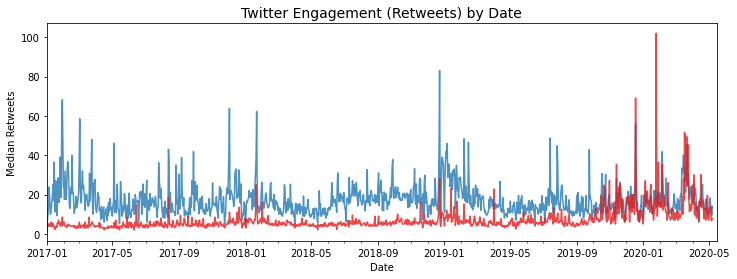

In [31]:
# Plot median democrat and republican retweets by date
dateMedianRetweetsDem['party'], dateMedianRetweetsRep['party'] = 'D', 'R'
dateMedianRetweetsDemRep = dateMedianRetweetsDem.append(dateMedianRetweetsRep)
dateMedianRetweetsDemRep['date'] = pd.to_datetime(dateMedianRetweetsDemRep['date'], format = '%Y-%m-%d')

fig, ax = plt.subplots(figsize = (12, 4))
sns.set_palette(["#1F78B4", "#E31A1C"])
sns.lineplot(x = 'date', y = 'retweets', data = dateMedianRetweetsDemRep, 
             hue = 'party', palette = ["#1F78B4", "#E31A1C"], alpha = 0.8)
plt.xlabel('Date')
plt.ylabel('Median Retweets')
plt.xlim(pd.to_datetime(['2017-01-01','2020-05-15'], format = '%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval = 1))
plt.title("Twitter Engagement (Retweets) by Date", fontsize = 14)
plt.legend([],[], frameon = False)
plt.show()

In [32]:
# Count number of favorites by date and user (take max favorite count per user on given date)
dateFavoriteCountsRDD = (tweetsRDD
                         .map(lambda tweet: ((parseDate(tweet['created_at']),
                                              tweet['user']['screen_name']),
                                             tweet['favorite_count']))
                         .reduceByKey(max)
                        )

In [33]:
# Convert to dataframe and sort by descending order
columns = ['date','user', 'favorites']
dateFavoriteCounts = dateFavoriteCountsRDD.map(lambda kv: (kv[0][0], kv[0][1], kv[1])).toDF(columns).toPandas()
dateFavoriteCounts = dateFavoriteCounts.sort_values('favorites', ascending = False)

In [34]:
# Calculate median favorites by date
dateMedianFavorites = dateFavoriteCounts.groupby('date').median().reset_index()
dateMedianFavorites = dateMedianFavorites.sort_values('favorites', ascending = False)
# dateMedianFavorites.to_csv("median_favorites_by_date.csv", header = True)
# dateMedianFavorites.head(10)

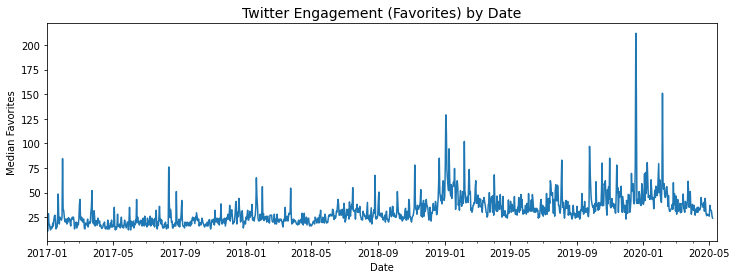

In [35]:
# Plot median favorites by date
dateMedianFavorites['date'] = pd.to_datetime(dateMedianFavorites['date'], format = '%Y-%m-%d')

fig, ax = plt.subplots(figsize = (12, 4))
sns.lineplot(x = 'date', y = 'favorites', data = dateMedianFavorites)
plt.xlabel('Date')
plt.ylabel('Median Favorites')
plt.xlim(pd.to_datetime(['2017-01-01','2020-05-15'], format = '%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval = 1))
plt.title("Twitter Engagement (Favorites) by Date", fontsize = 14)
plt.show()

In [36]:
# Count word usage frequency
wordCountsRDD = (tweetsRDD
                 .flatMap(lambda tweet: [word for word in preprocessText(tweet['full_text'])])
                 .map(lambda word: (word, 1))
                 .reduceByKey(lambda a, b: a + b)
                )

# return most used words
# wordCountsRDD.takeOrdered(100, lambda kv: -kv[1])